Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 400 images in the folder
Processing preview: 00272.png
Applying realistic aging effects


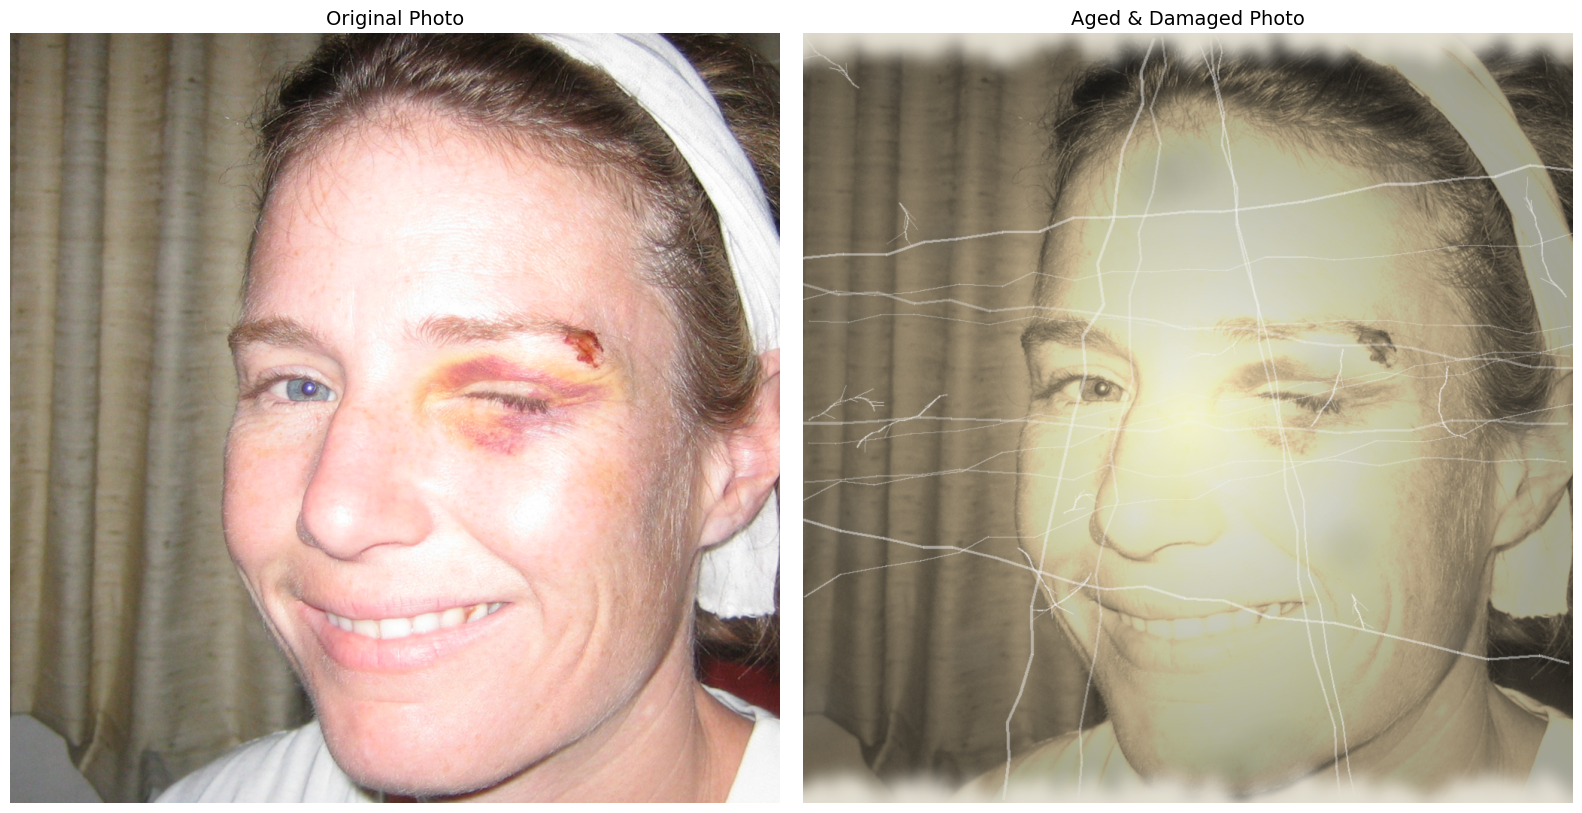

Preview saved: /content/drive/MyDrive/DL_Project/data_aged/aged_00272.png

Processing all 400 images

All 400 images processed!


In [5]:
import numpy as np
import cv2
from google.colab import drive
from PIL import Image, ImageEnhance, ImageFilter, ImageDraw
import matplotlib.pyplot as plt
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your images folder
image_folder = '/content/drive/MyDrive/DL_Project/data'
output_folder = '/content/drive/MyDrive/DL_Project/data_aged'
os.makedirs(output_folder, exist_ok=True)

# Get all image files
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
image_files = [f for f in os.listdir(image_folder)
               if any(f.lower().endswith(ext) for ext in image_extensions)]

print(f"Found {len(image_files)} images in the folder")

# Load first image for preview
img_name = image_files[0]
img_path = os.path.join(image_folder, img_name)
img = Image.open(img_path).convert('RGB')
img_array = np.array(img).astype(np.float32)
print(f"Processing preview: {img_name}")

# 1. Apply sepia tone
def apply_sepia(img_array):
    sepia_filter = np.array([[0.393, 0.769, 0.189],
                              [0.349, 0.686, 0.168],
                              [0.272, 0.534, 0.131]])
    sepia_img = img_array @ sepia_filter.T
    sepia_img = np.clip(sepia_img, 0, 255)
    return sepia_img

# 2. Add realistic creases
def add_creases(img_array, num_creases=5):
    h, w = img_array.shape[:2]
    img = Image.fromarray(img_array.astype(np.uint8))
    draw = ImageDraw.Draw(img, 'RGBA')

    for _ in range(num_creases):
        # Create crease path
        if np.random.random() > 0.5:
            x1 = np.random.randint(w//4, 3*w//4)
            y1 = 0
            x2 = x1 + np.random.randint(-w//4, w//4)
            y2 = h
        else:
            x1 = 0
            y1 = np.random.randint(h//4, 3*h//4)
            x2 = w
            y2 = y1 + np.random.randint(-h//4, h//4)

        # Draw wavy crease
        points = []
        num_segments = 20
        for i in range(num_segments + 1):
            t = i / num_segments
            x = x1 + (x2 - x1) * t + np.random.randint(-10, 10)
            y = y1 + (y2 - y1) * t + np.random.randint(-10, 10)
            points.append((int(x), int(y)))

        # Draw semi-transparent white line
        width = np.random.randint(2, 5)
        alpha = np.random.randint(80, 150)
        for i in range(len(points) - 1):
            draw.line([points[i], points[i+1]],
                     fill=(255, 255, 255, alpha), width=width)

    return np.array(img).astype(np.float32)

# 3. Add cracks (branching)
def add_cracks(img_array, num_cracks=3):
    h, w = img_array.shape[:2]
    img = Image.fromarray(img_array.astype(np.uint8))
    draw = ImageDraw.Draw(img, 'RGBA')

    for _ in range(num_cracks):
        x, y = np.random.randint(w), np.random.randint(h)
        angle = np.random.uniform(0, 7 * np.pi)
        length = np.random.randint(50, 150)

        # Main crack
        points = [(x, y)]
        for step in range(15):
            angle += np.random.uniform(-0.4, 0.4)
            step_len = length / 15
            x += step_len * np.cos(angle)
            y += step_len * np.sin(angle)
            points.append((int(x), int(y)))

            # Add small branches
            if np.random.random() > 0.7:
                branch_angle = angle + np.random.uniform(-1, 1)
                branch_len = np.random.randint(10, 30)
                bx = x + branch_len * np.cos(branch_angle)
                by = y + branch_len * np.sin(branch_angle)
                alpha = np.random.randint(100, 180)
                draw.line([(int(x), int(y)), (int(bx), int(by))],
                         fill=(255, 255, 255, alpha), width=1)

        # Draw main crack
        alpha = np.random.randint(120, 200)
        for i in range(len(points) - 1):
            draw.line([points[i], points[i+1]],
                     fill=(255, 255, 255, alpha), width=2)

    return np.array(img).astype(np.float32)

# 4. Add torn edges
def add_torn_edges(img_array, intensity=40):
    h, w = img_array.shape[:2]
    img = Image.fromarray(img_array.astype(np.uint8))
    mask = Image.new('L', (w, h), 255)
    draw = ImageDraw.Draw(mask)

    # Randomly damage edges
    edges_to_damage = np.random.choice(['top', 'bottom', 'left', 'right'],
                                       size=np.random.randint(1, 3), replace=False)

    for edge in edges_to_damage:
        if edge == 'top':
            for x in range(0, w, 8):
                depth = np.random.randint(0, intensity)
                width = np.random.randint(10, 30)
                draw.ellipse([x-width//2, -depth, x+width//2, depth], fill=0)
        elif edge == 'bottom':
            for x in range(0, w, 8):
                depth = np.random.randint(0, intensity)
                width = np.random.randint(10, 30)
                draw.ellipse([x-width//2, h-depth, x+width//2, h+depth], fill=0)
        elif edge == 'left':
            for y in range(0, h, 8):
                depth = np.random.randint(0, intensity)
                width = np.random.randint(10, 30)
                draw.ellipse([-depth, y-width//2, depth, y+width//2], fill=0)
        elif edge == 'right':
            for y in range(0, h, 8):
                depth = np.random.randint(0, intensity)
                width = np.random.randint(10, 30)
                draw.ellipse([w-depth, y-width//2, w+depth, y+width//2], fill=0)

    # Blur mask for soft edges
    mask = mask.filter(ImageFilter.GaussianBlur(10))

    # Apply mask
    img_array = np.array(img).astype(np.float32)
    mask_array = np.array(mask).astype(np.float32) / 255.0
    mask_3ch = np.stack([mask_array] * 3, axis=2)

    # Blend to aged paper color
    paper_color = np.array([235, 230, 215])
    result = img_array * mask_3ch + paper_color * (1 - mask_3ch)

    return result

# 5. Add stains
def add_stains(img_array, num_stains=10):
    h, w = img_array.shape[:2]
    img = Image.fromarray(img_array.astype(np.uint8))

    for _ in range(num_stains):
        x, y = np.random.randint(w), np.random.randint(h)
        radius = np.random.randint(15, 60)

        # Create stain overlay
        stain = Image.new('RGBA', (w, h), (0, 0, 0, 0))
        draw = ImageDraw.Draw(stain)

        color_val = np.random.randint(100, 150)
        alpha = np.random.randint(20, 60)
        draw.ellipse([x-radius, y-radius, x+radius, y+radius],
                    fill=(color_val, color_val, color_val, alpha))

        # Blur for natural look
        stain = stain.filter(ImageFilter.GaussianBlur(15))
        img = Image.alpha_composite(img.convert('RGBA'), stain)

    return np.array(img.convert('RGB')).astype(np.float32)

# 6. Add vignette
def add_vignette(img_array, intensity=0.35):
    h, w = img_array.shape[:2]
    X, Y = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
    radius = np.sqrt(X**2 + Y**2)
    vignette = 1 - intensity * np.clip(radius, 0, 1)
    vignette = np.stack([vignette] * 3, axis=2)
    return img_array * vignette

# Apply all effects to preview
print("Applying realistic aging effects")
damaged_img = apply_sepia(img_array)
damaged_img = add_vignette(damaged_img)
damaged_img = add_stains(damaged_img, num_stains=18)
damaged_img = add_creases(damaged_img, num_creases=14)
damaged_img = add_cracks(damaged_img, num_cracks=13)
damaged_img = add_torn_edges(damaged_img, intensity=45)

# Final adjustments
damaged_img = np.clip(damaged_img, 0, 255).astype(np.uint8)
pil_img = Image.fromarray(damaged_img)
pil_img = pil_img.filter(ImageFilter.GaussianBlur(0.5))
enhancer = ImageEnhance.Contrast(pil_img)
pil_img = enhancer.enhance(0.9)
damaged_img = np.array(pil_img)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(img_array.astype(np.uint8))
axes[0].set_title('Original Photo', fontsize=14)
axes[0].axis('off')

axes[1].imshow(damaged_img)
axes[1].set_title('Aged & Damaged Photo', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Save preview
output = Image.fromarray(damaged_img)
output_path = os.path.join(output_folder, 'aged_' + img_name)
output.save(output_path)
print(f"Preview saved: {output_path}")

# Process all images
print("\n" + "="*50)
print(f"Processing all {len(image_files)} images")

for idx, img_name in enumerate(image_files, 1):
    try:
        # print(f"Processing {idx}/{len(image_files)}: {img_name}")

        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img).astype(np.float32)

        # Apply effects
        damaged_img = apply_sepia(img_array)
        damaged_img = add_vignette(damaged_img)
        damaged_img = add_stains(damaged_img, num_stains=np.random.randint(6, 12))
        damaged_img = add_creases(damaged_img, num_creases=np.random.randint(3, 6))
        damaged_img = add_cracks(damaged_img, num_cracks=np.random.randint(2, 4))
        damaged_img = add_torn_edges(damaged_img, intensity=np.random.randint(25, 45))

        damaged_img = np.clip(damaged_img, 0, 255).astype(np.uint8)
        pil_img = Image.fromarray(damaged_img)
        pil_img = pil_img.filter(ImageFilter.GaussianBlur(0.5))
        enhancer = ImageEnhance.Contrast(pil_img)
        pil_img = enhancer.enhance(0.9)
        damaged_img = np.array(pil_img)

        output = Image.fromarray(damaged_img)
        output_path = os.path.join(output_folder, 'aged_' + img_name)
        output.save(output_path)

    except Exception as e:
        print(f"Error processing {img_name}: {str(e)}")

print(f"\nAll {len(image_files)} images processed!")